In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import os

from env import get_db_url
from acquire import get_db_log_data
from wrangle import wrangle_df

# Acquire:

I need to figure out why these are coming out differently after the join. 
- There's a difference of 52,887 records.
    - It looks like the difference here is due to having 52,893 null values in logs.cohort_id.
    - There are 6 cohorts in the cohorts_id table that do not have any server traffic, so perhaps they didn't exist.
    - 52,887 that didn't have anything to tie them to the cohorts table. Probably cohort ids - come back and verify.
- it appears that there there are some IDs and Cohort IDs that do not much.

## Importing from the database using SQL

In [2]:
df = get_db_log_data()

In [3]:
df.sample(5)

,date,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
95695,2018-08-01,11:29:32,slides/inheritance_and_polymorphism,188,24.0,97.105.19.58,24.0,Voyageurs,#voyageurs,2018-05-29,2018-10-11,2018-05-25 22:25:57,2018-05-25 22:25:57,NaN,2.0
271540,2019-05-23,16:33:48,13.1_Understand,372,NaN,97.105.19.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
686585,2020-09-30,09:33:43,javascript-i/introduction,732,61.0,72.179.177.9,61.0,Bash,#bash,2020-07-20,2021-01-21,2020-07-20 19:04:00,2020-09-30 15:54:46,NaN,2.0
630698,2020-08-06,17:31:20,javascript-i,714,NaN,70.123.200.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104260,2018-08-14,08:12:49,javascript-i/arrays/manipulating,234,25.0,97.105.19.58,25.0,Wrangell,#wrangell,2018-07-23,2018-11-29,2018-07-23 15:02:25,2018-07-23 15:02:25,NaN,2.0


# Wrangle:

## To-Do:
    - Figure out what created_at and updated_at columns are. 

In [4]:
df = wrangle_df(df)

In [5]:
df.sample(5)

,date,time,path,user_id,cohort_id,ip,name,start_date,end_date,created_at,updated_at,program_id
199431,2019-02-15,2022-07-11 09:00:13,javascript-i,324,29.0,97.105.19.58,Zion,2019-01-22,2019-06-04,2019-01-20 23:18:57,2019-01-20 23:18:57,full_stack_java
265011,2019-05-12,2022-07-11 21:38:29,2.00.05_Charts_PivotTables_Sparklines,405,6.0,136.49.177.117,Franklin,2015-02-03,2015-05-26,2016-06-14 19:52:26,2016-06-14 19:52:26,full_stack_php
240994,2019-04-10,2022-07-11 14:59:48,slides/introduction_to_java,344,29.0,97.105.19.58,Zion,2019-01-22,2019-06-04,2019-01-20 23:18:57,2019-01-20 23:18:57,full_stack_java
464324,2020-02-24,2022-07-11 06:08:04,10-anomaly-detection/4-detecting-timeseries-an...,476,34.0,136.50.49.145,Bayes,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,data_science
91218,2018-07-25,2022-07-11 18:48:42,content/javascript/introduction-to-javascript....,241,17.0,108.73.55.208,Olympic,2017-02-06,2017-05-25,2017-02-06 17:49:10,2017-02-06 17:49:10,full_stack_php


In [6]:
df['tenure'] = df.end_date - df.start_date

In [7]:
df.head()

,date,time,path,user_id,cohort_id,ip,name,start_date,end_date,created_at,updated_at,program_id,tenure
0,2018-01-26,2022-07-11 09:55:03,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,full_stack_php,137 days
1,2018-01-26,2022-07-11 09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,full_stack_php,137 days
2,2018-01-26,2022-07-11 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,full_stack_php,137 days
3,2018-01-26,2022-07-11 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,full_stack_php,137 days
4,2018-01-26,2022-07-11 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,full_stack_java,129 days


In [8]:
df[(df.date < df.end_date) & (df.date > df.start_date)]

,date,time,path,user_id,cohort_id,ip,name,start_date,end_date,created_at,updated_at,program_id,tenure
4,2018-01-26,2022-07-11 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,full_stack_java,129 days
5,2018-01-26,2022-07-11 09:56:41,javascript-i/loops,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,full_stack_java,129 days
6,2018-01-26,2022-07-11 09:56:46,javascript-i/conditionals,3,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,full_stack_java,129 days
7,2018-01-26,2022-07-11 09:56:48,javascript-i/functions,3,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,full_stack_java,129 days
8,2018-01-26,2022-07-11 09:56:59,javascript-i/loops,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,full_stack_java,129 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...
900210,2021-04-21,2022-07-11 16:36:09,jquery/personal-site,869,135.0,136.50.98.51,Marco,2021-01-25,2021-07-19,2021-01-20 21:31:11,2021-01-20 21:31:11,full_stack_java,175 days
900211,2021-04-21,2022-07-11 16:36:34,html-css/css-ii/bootstrap-grid-system,948,138.0,104.48.214.211,Neptune,2021-03-15,2021-09-03,2021-03-15 19:57:09,2021-03-15 19:57:09,full_stack_java,172 days
900212,2021-04-21,2022-07-11 16:37:48,java-iii,834,134.0,67.11.50.23,Luna,2020-12-07,2021-06-08,2020-12-07 16:58:43,2020-12-07 16:58:43,full_stack_java,183 days
900213,2021-04-21,2022-07-11 16:38:14,java-iii/servlets,834,134.0,67.11.50.23,Luna,2020-12-07,2021-06-08,2020-12-07 16:58:43,2020-12-07 16:58:43,full_stack_java,183 days


# Questions:

## 5. At some point in 2019, the ability for students and alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?

### Finding logs of student access for the year of 2019:

In [9]:
first_date = dt.datetime(2018, 12, 31)
second_date = dt.datetime(2020, 1, 1)

log_2019 = df[(df.date > first_date) & (df.date < second_date)]

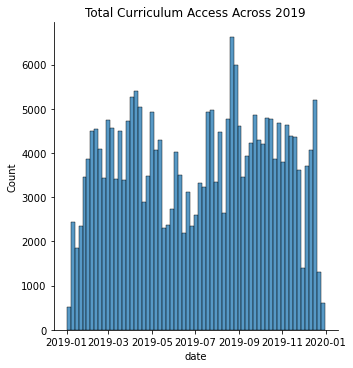

In [10]:
sns.displot(data = log_2019, x = log_2019.date).set(title = "Total Curriculum Access Across 2019");

### Trying to Identify Instances of Students Accessing Other Curriculum:

In [11]:
def program_type(df):
    df['program_type'] = pd.Series()
    if df.program_id != 'data_science':
        df.program_type ='web'
    elif df.program_id == 'data_science':
        df.program_type = 'data'
    return df

In [12]:
df2 = df.sample(10)

In [13]:
#df2.apply(program_type, 1)

In [14]:
df[df.program_id.isnull()]

,date,time,path,user_id,cohort_id,ip,name,start_date,end_date,created_at,updated_at,program_id,tenure
411,2018-01-26,2022-07-11 16:46:16,/,48,NaN,97.105.19.61,NaN,NaT,NaT,NaT,NaT,NaN,NaT
412,2018-01-26,2022-07-11 16:46:24,spring/extra-features/form-validation,48,NaN,97.105.19.61,NaN,NaT,NaT,NaT,NaT,NaN,NaT
425,2018-01-26,2022-07-11 17:54:24,/,48,NaN,97.105.19.61,NaN,NaT,NaT,NaT,NaT,NaN,NaT
435,2018-01-26,2022-07-11 18:32:03,/,48,NaN,97.105.19.61,NaN,NaT,NaT,NaT,NaT,NaN,NaT
436,2018-01-26,2022-07-11 18:32:17,mysql/relationships/joins,48,NaN,97.105.19.61,NaN,NaT,NaT,NaT,NaT,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
899897,2021-04-21,2022-07-11 12:49:00,javascript-ii,717,NaN,136.50.102.126,NaN,NaT,NaT,NaT,NaT,NaN,NaT
899898,2021-04-21,2022-07-11 12:49:02,javascript-ii/es6,717,NaN,136.50.102.126,NaN,NaT,NaT,NaT,NaT,NaN,NaT
899899,2021-04-21,2022-07-11 12:51:27,javascript-ii/map-filter-reduce,717,NaN,136.50.102.126,NaN,NaT,NaT,NaT,NaT,NaN,NaT
899900,2021-04-21,2022-07-11 12:52:37,javascript-ii/promises,717,NaN,136.50.102.126,NaN,NaT,NaT,NaT,NaT,NaN,NaT


In [15]:
data_students = df[df.program_id == 'data_science']
web_students = df[(df.program_id != 'data_science') & (df.program_id != None)].dropna()

In [25]:
web_students

,date,time,path,user_id,cohort_id,ip,name,start_date,end_date,created_at,updated_at,program_id,tenure
0,2018-01-26,2022-07-11 09:55:03,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,full_stack_php,137 days
1,2018-01-26,2022-07-11 09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,full_stack_php,137 days
2,2018-01-26,2022-07-11 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,full_stack_php,137 days
3,2018-01-26,2022-07-11 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,full_stack_php,137 days
4,2018-01-26,2022-07-11 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,full_stack_java,129 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...
900218,2021-04-21,2022-07-11 16:41:51,jquery/personal-site,64,28.0,71.150.217.33,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,full_stack_java,0 days
900219,2021-04-21,2022-07-11 16:42:02,jquery/mapbox-api,64,28.0,71.150.217.33,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,full_stack_java,0 days
900220,2021-04-21,2022-07-11 16:42:09,jquery/ajax/weather-map,64,28.0,71.150.217.33,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,full_stack_java,0 days
900221,2021-04-21,2022-07-11 16:44:37,anomaly-detection/discrete-probabilistic-methods,744,28.0,24.160.137.86,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,full_stack_java,0 days


In [17]:
data_students

,date,time,path,user_id,cohort_id,ip,name,start_date,end_date,created_at,updated_at,program_id,tenure
326053,2019-08-20,2022-07-11 09:39:58,/,466,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,data_science,164 days
326054,2019-08-20,2022-07-11 09:39:59,/,467,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,data_science,164 days
326055,2019-08-20,2022-07-11 09:39:59,/,468,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,data_science,164 days
326056,2019-08-20,2022-07-11 09:40:02,/,469,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,data_science,164 days
326057,2019-08-20,2022-07-11 09:40:08,/,470,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,data_science,164 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...
900182,2021-04-21,2022-07-11 16:14:16,regression/project,841,133.0,99.162.244.233,Easley,2020-12-07,2021-06-08,2020-12-07 15:20:18,2020-12-07 15:20:18,data_science,183 days
900183,2021-04-21,2022-07-11 16:15:51,regression/project,841,133.0,99.162.244.233,Easley,2020-12-07,2021-06-08,2020-12-07 15:20:18,2020-12-07 15:20:18,data_science,183 days
900190,2021-04-21,2022-07-11 16:23:53,/,143,133.0,173.174.194.60,Easley,2020-12-07,2021-06-08,2020-12-07 15:20:18,2020-12-07 15:20:18,data_science,183 days
900191,2021-04-21,2022-07-11 16:23:57,clustering/project,841,133.0,99.162.244.233,Easley,2020-12-07,2021-06-08,2020-12-07 15:20:18,2020-12-07 15:20:18,data_science,183 days


In [18]:
web_students

,date,time,path,user_id,cohort_id,ip,name,start_date,end_date,created_at,updated_at,program_id,tenure
0,2018-01-26,2022-07-11 09:55:03,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,full_stack_php,137 days
1,2018-01-26,2022-07-11 09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,full_stack_php,137 days
2,2018-01-26,2022-07-11 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,full_stack_php,137 days
3,2018-01-26,2022-07-11 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,full_stack_php,137 days
4,2018-01-26,2022-07-11 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,full_stack_java,129 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...
900218,2021-04-21,2022-07-11 16:41:51,jquery/personal-site,64,28.0,71.150.217.33,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,full_stack_java,0 days
900219,2021-04-21,2022-07-11 16:42:02,jquery/mapbox-api,64,28.0,71.150.217.33,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,full_stack_java,0 days
900220,2021-04-21,2022-07-11 16:42:09,jquery/ajax/weather-map,64,28.0,71.150.217.33,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,full_stack_java,0 days
900221,2021-04-21,2022-07-11 16:44:37,anomaly-detection/discrete-probabilistic-methods,744,28.0,24.160.137.86,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,full_stack_java,0 days


In [19]:
data_students.shape[0] + web_students.shape[0] == df.shape[0]

False

In [26]:
#This is the function that takes 5 ever:

#df.apply(program_type, 1)

In [21]:
web_to_data = df[(df.program_id == 'full_stack_java') & df.path]

In [22]:
df.program_id.unique()

array(['full_stack_php', 'full_stack_java', nan, 'front_end_programming',
       'data_science'], dtype=object)

## 6. What topics are grads continuing to reference after graduation and into their jobs (for each program)?

## 7. Which lessons are least accessed?

In [23]:
df.path.value_counts()

/                                                               50313
search/search_index.json                                        19519
javascript-i                                                    18983
toc                                                             18297
java-iii                                                        13733
                                                                ...  
javascript/loops                                                    1
content/control-structures-ii                                       1
javascript-ii/promisesdfghjkjhgfs                                   1
app                                                                 1
appendix/professional-development/post-interview-review-form        1
Name: path, Length: 2313, dtype: int64

In [24]:
unique_paths = pd.DataFrame(df.path.value_counts())

## 8. Anything else I should be aware of?